# Learning `scan` with `jax` and `numpyro` for Time Series

Learning `scan` - it's all over the `numpyro` time series examples so if I want to implement time series in Numpyro from scratch, I'll need to better understand it.

In the context of time series models, `scan` is helpful because it allows us to iterate over sequences (without a cumbersome `for` loop) while maintaining state across each iteration. 

## `scan` components:

1. **Input Function `f(carry, x)`**: `scan` takes an input function $f$ that defines the computation you want to perform at each step. This function typically takes two arguments:
   1. `carry`: A tuple that represents the state or context at the current time step. This is passed from one iteration to the next, allowing you to maintain and update state across time steps.
   2. `x`: The current element from the input sequence or array.
2. **Initial State `init`**: You also provide an initial state or `carry`` value. This is the state that the computation starts with at the first time step.
3. **Array sequence `xs`**: An iterable or sequence that you want to iterate over

Then `scan` will do the following:

* **Sequencing**
  * The `scan` function applies the provided function to each element in the input sequence in order, passing the current carry value and the current element x to the function. It iterates over the entire sequence.
* **Aggregation**
  * The output of the function at each time step can be used to produce an output sequence, and the final `carry` value at the last time step can represent the final state. The resulting sequences or values can be collected and returned.

The Input function also returns two items:

1. The carried over value(s), aka the latest state
2. An array, where each element is something returned from the Input Function `f` as it passes each element in `xs`



In [61]:
from jax import random
import jax.numpy as jnp

## Trival Example 1 - Cumulative Sum

* [From The Differential Programming Tutorial - Loopy Carry, by Eric Ma](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html)

We'll start with the cumsum example from [From The Differential Programming Tutorial - Loopy Carry, by Eric Ma](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html). We can implement a cumsum with a `for` loop like:

In [62]:
# xs
xs = jnp.array([1, 2, 3, 5, 7, 11, 13, 17])

result = []
cumsum = 0
for el in xs:
    cumsum += el
    result.append(cumsum)
jnp.array(result)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

This is identical to the cumulative sum:

In [63]:
jnp.cumsum(xs)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

Now, instead of a for loop, we rewrite it using `lax.scan`:

In [64]:
from jax import lax

def cumsum(cumsum, el):
    """
    Parameters
    ----------
    cumsum
        The result from the previous loop, aka the 'carried over' result
    el
        The current element in the sequence in `xs`
    """
    cumsum += el
    return cumsum, cumsum # ('carryover', 'accumulated')

init_sum = 0
final, result = lax.scan(cumsum, init_sum, xs)
print(final)
print(result)

59
[ 1  3  6 11 18 29 42 59]


we see that `lax.scan` returned two things: 
* The first item is the latest value of `res`
* The second item being returned is an array where each iteration appended the latest value of `res` to the end.

## Trivial Example 2: A little more of the carry function

The first two parameters in the input function can have arbitrary names but their order matters. The first item is the 'carried over value' and the second item is the current element in the `xs` input array.

Similarly the input function must have two outputs. The first output becomes the new 'carried over value' that will feed back into the input function, while the second output gets appended to an output `jax` array.

Let's have a concrete example in which we calculate compounded interest for a $100 investment with a 4% interest rate:

In [65]:
# Define a function to apply at each time step
def interest_growth(value, x):
    value = value * 1.04
    return value, value # ('carried over value', 'accumulated array')

# Define the initial state and input sequence
init_state = 100.0
T = jnp.array([1, 2, 3, 4, 5])
T = jnp.arange(1, 30)

# Apply the scan function
# scan(f, init, xs, length=None, reverse=False, history=1)
final_state, results = lax.scan(f=interest_growth, init=init_state, xs=T)

print(final_state)
print(results)

311.8648
[104.       108.159996 112.48639  116.98584  121.66527  126.531876
 131.59314  136.85686  142.33113  148.02437  153.94534  160.10315
 166.50726  173.16754  180.09424  187.298    194.78992  202.58151
 210.68477  219.11215  227.87663  236.99168  246.47134  256.3302
 266.5834   277.24673  288.33658  299.87003  311.8648  ]


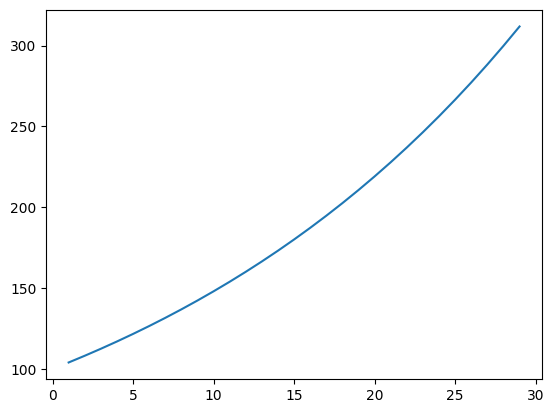

In [66]:
import matplotlib.pyplot as plt

plt.plot(T, results);

And we see the effect of the interest compounding over time.

## Trivial Example 3: `scan` in Numpyro to sample from a distribution

And what I'm really interested in is learning `scan` in the context of doing time series in `numpyro`. 

`numpyro` has it's own (experimental) implementation of `scan` which allows us to iteratively sample from `numpyro` primitives like `numpyro.distributions`. 

Here's a simple example of a random walk:

$$
y_{t+1} = y_t + \epsilon, \quad \epsilon \sim \mathcal{N}(0,1)
$$

Or, equivalently:

$$
\begin{aligned}
y_t &= \mu_t\\
\mu_{t+1} &= \mu_t + \epsilon_\mu, \quad \epsilon_\mu \sim \mathcal{N}(0, 1)\\
\end{aligned}
$$

To do this within a `scan` we'll also need to introduce an *effect handler*: `numpyro.handlers.seed` and run the `scan` function within that context.

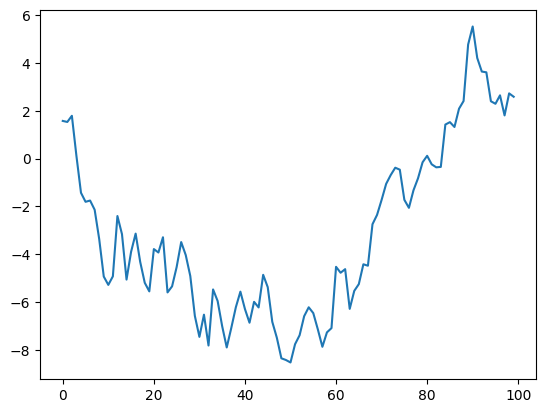

In [24]:
# Import libraries
import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
import matplotlib.pyplot as plt

# Define our random walk function as an input into `scan`
def random_walk(value, x):    
    value = numpyro.sample('x', dist.Normal(value, 1.))
    # Which is the same as if we were very explicit:
    # value = value + numpyro.sample('x', dist.Normal(0, 1.))
    return value, value

init_0 = 0
T = jnp.arange(100)

# Need the `seed` effect handler in a context manager because of
# the need for a PRNG key within `numpyro.sample`
with numpyro.handlers.seed(rng_seed=42):
    final_location, locations = scan(random_walk, init=init_0, xs=T)

plt.plot(T, locations);

Note the addition of `numpyro.handlers.seed`. This is required due to how `numpyro` requires an explicit PRNG key when you `sample` from a distribution, so this `seed` effect handler will automatically do the `split`s on the key within each loop of the `scan` function. 

Otherwise, if you set up an explicit key with `scan` this is what you'd get:

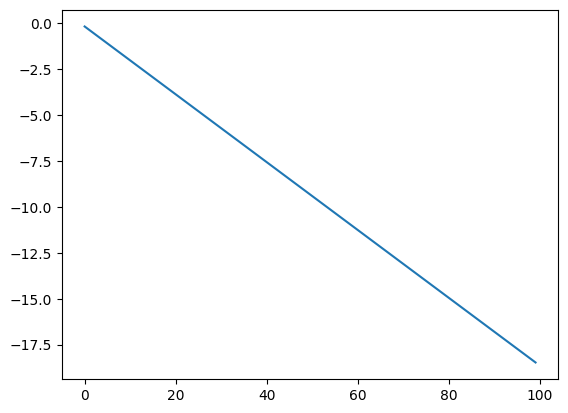

In [25]:
prng_key = random.PRNGKey(42)

def random_walk_nokey(value, x):
    # Being really explicit here
    value = value + numpyro.sample('x', dist.Normal(0, 1.), rng_key=prng_key)
    return value, value

init_0 = 0
n_steps = 100

state, final_result = scan(random_walk_nokey, init=init_0, xs=jnp.arange(n_steps))

plt.plot(jnp.arange(n_steps), final_result);

So that's why you need to use the handler!